## Reload the `EC_estimator.py` code to consider any changes

In [1]:
#reload model magic
%load_ext autoreload
%autoreload 2

import EC_estimator as annec

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
import EC_estimator as annec
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [3]:
tf.__version__

'2.2.0'

## Load the dataset, preprocessing, and apply ANN model

In [4]:
import numpy as np
import pandas as pd

import EC_estimator as annec

# ------------------------------------------------------------
# Settings
# ------------------------------------------------------------
predictors = ["dcc", "exports", "sac", "sjr", "tide", "net_dcd", "smscg"]
target = "EC"
WINDOW = 118  # 1 + 7 + (10*11)

test_start  = "1923-01-01"
test_end    = "1939-12-31"
train_start = "1940-01-01"
train_end   = "2015-12-31"


# ------------------------------------------------------------
# Helper: create sliding windows
# ------------------------------------------------------------
def make_windows(df_raw: pd.DataFrame, predictors, target, window: int):
    """
    Builds:
      X_seq: (N, window, n_predictors)
      y:     (N, 1)

    Backward alignment:
      window rows are [t-window+1, ..., t]  (history ending at t)
      y is df_raw[target].iloc[t]
    """
    X_all = df_raw[predictors].to_numpy()
    y_all = df_raw[target].to_numpy().reshape(-1, 1)

    if len(df_raw) < window:
        raise ValueError(f"Not enough rows ({len(df_raw)}) to build a window of {window}.")

    Xw = []
    yw = []

    # t is the "current day" index
    for t in range(window - 1, len(df_raw)):
        Xw.append(X_all[t - window + 1 : t + 1, :])  # (window, n_predictors), ends at t
        yw.append(y_all[t])                          # target at t

    X_seq = np.stack(Xw, axis=0)
    y = np.vstack(yw)
    return X_seq, y



# ------------------------------------------------------------
# Load raw daily data (date + 7 predictors + EC)
# ------------------------------------------------------------
df = annec.load_data("Inputs/EC_inputs.csv")

df["date"] = pd.to_datetime(df["date"], errors="raise")
df = df.sort_values("date")

# Keep date for splitting; do NOT convert to MultiIndex lags
df = df.reset_index(drop=True)

# Sanity check columns
missing_cols = [c for c in (["date"] + predictors + [target]) if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in EC_inputs.csv: {missing_cols}")


# ------------------------------------------------------------
# Split by date ranges on raw data
# ------------------------------------------------------------
df_test_raw  = df[(df["date"] >= test_start) & (df["date"] <= test_end)].copy()
df_train_raw = df[(df["date"] >= train_start) & (df["date"] <= train_end)].copy()

if df_test_raw.empty:
    raise ValueError("df_test_raw is empty. Check that dates exist in 1923–1939.")
if df_train_raw.empty:
    raise ValueError("df_train_raw is empty. Check that dates exist in 1940–2015.")

print("Train:", df_train_raw["date"].min().date(), "→", df_train_raw["date"].max().date(), "rows:", len(df_train_raw))
print("Test :", df_test_raw["date"].min().date(),  "→", df_test_raw["date"].max().date(),  "rows:", len(df_test_raw))


# ------------------------------------------------------------
# Build raw windows (118 days × 7 predictors)
# ------------------------------------------------------------
X_train_seq, y_train_arr = make_windows(df_train_raw, predictors, target, WINDOW)
X_test_seq,  y_test_arr  = make_windows(df_test_raw,  predictors, target, WINDOW)

# Convert to "7 inputs" format: each is (N,118)
X_train = [X_train_seq[:, :, i] for i in range(len(predictors))]
X_test  = [X_test_seq[:, :, i]  for i in range(len(predictors))]

# Targets as DataFrame (keeps your existing train_model interface happy)
y_train = pd.DataFrame(y_train_arr, columns=[target])
y_test  = pd.DataFrame(y_test_arr,  columns=[target])

print("X_train shapes:", [x.shape for x in X_train])  # expect 7 × (N,118)
print("y_train shape :", y_train.shape)
print(f"Test set size: {len(y_test)} samples")


# ------------------------------------------------------------
# Build model (inputs are now raw 118-day vectors)
# ------------------------------------------------------------
# Build model inputs (should create 7 Input(shape=(118,), ...))
inputs = annec.build_model_inputs(None)

# Preprocessing layers:
# IMPORTANT: normalize using TRAIN only (no leakage).
layers = annec.preprocessing_layers(df_train_raw, inputs, X_train)

neurons = [8, 2, 1]
activations = ["sigmoid", "sigmoid"]
model, tensorboard_cb = annec.build_model(layers, inputs)

# ------------------------------------------------------------
# Train
# (Early stopping now uses patience=50 instead of 1000)
# ------------------------------------------------------------
history, model = annec.train_model(model, tensorboard_cb, X_train, y_train, X_test, y_test)

Train: 1940-01-01 → 2015-09-29 rows: 27666
Test : 1923-04-28 → 1939-12-31 rows: 6092
X_train shapes: [(27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118), (27549, 118)]
y_train shape : (27549, 1)
Test set size: 5975 samples


## Evaluation of the model

In [5]:
# Calculate metrics for ANN
#print(model.summary())
metrics = []
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

print("predictions (last 3)")
print("train:", y_train_pred[-3:].ravel())
print("test :", y_test_pred[-3:].ravel())

print("\ninputs (feature 0 = dcc) last 3 windows, first 10 values of each window:")
print("train dcc:", X_train[0][-3:, :10])  # numpy slicing (N,118)
print("test  dcc:", X_test[0][-3:, :10])

# Since calculate_metrics expects y as arrays, pass arrays
y_train_true = y_train.values  # (N,1)
y_test_true  = y_test.values   # (N,1)

# annec.calculate_metrics already handles DataFrames, then can pass y_train/y_test directly.
metrics.append(
    annec.calculate_metrics("ANN", y_train, y_train_pred, y_test, y_test_pred)

)

df3 = pd.DataFrame(metrics)
print(df3)



predictions (last 3)
train: [122.00724 122.00724 122.00724]
test : [122.00724 122.00724 122.00724]

inputs (feature 0 = dcc) last 3 windows, first 10 values of each window:
train dcc: [[26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]
 [26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]
 [26. 26. 26. 26. 26. 26. 26. 26. 26. 26.]]
test  dcc: [[30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]]
  Model  Train_R2  Train_RMSE  Train_Percentage_Bias  Test_R2  Test_RMSE  \
0   ANN     -0.51      1068.9                 -62.62    -0.89    1504.05   

   Test_Percentage_Bias  
0                -72.62  


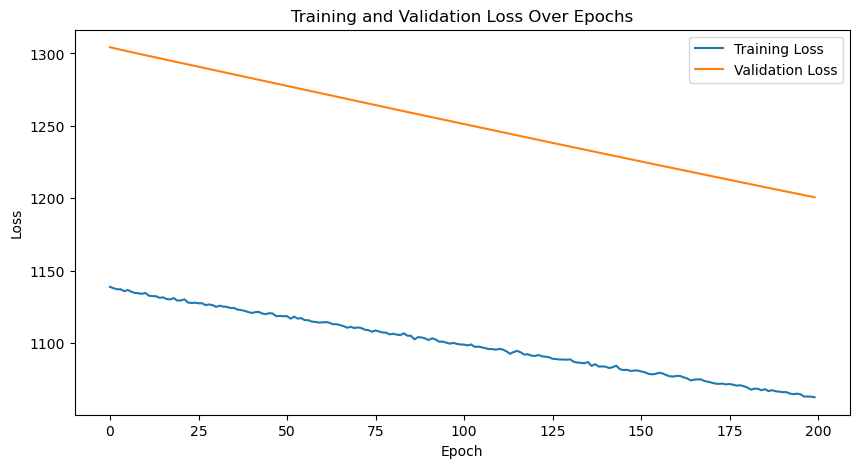

In [6]:
annec.plot_history(history)

In [ ]:
# Debug: Check each layer's output variance
print("=== Layer-by-layer variance check ===")
import tensorflow as tf

# Get 100 samples
test_X = [x[:100] for x in X_train]

# Check each layer
layer_names = ['concatenate', 'dense', 'hidden', 'emm_ec']
for name in layer_names:
    try:
        layer = model.get_layer(name)
        debug_model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
        out = debug_model.predict(test_X, verbose=0)
        print(f"{name}: shape={out.shape}, min={out.min():.4f}, max={out.max():.4f}, std={out.std():.6f}")
    except Exception as e:
        print(f"{name}: error - {e}")

# Also check raw antecedent layer
print("\n=== Antecedent outputs ===")
ant_layer = model.get_layer('dcc_antecedents')
ant_model = tf.keras.Model(inputs=model.inputs, outputs=ant_layer.output)
ant_out = ant_model.predict(test_X, verbose=0)
print(f"dcc_antecedents: shape={ant_out.shape}, min={ant_out.min():.4f}, max={ant_out.max():.4f}, std={ant_out.std():.6f}")

# Check normalized output
norm_layer = model.get_layer('dcc_norm')
norm_model = tf.keras.Model(inputs=model.inputs, outputs=norm_layer.output)
norm_out = norm_model.predict(test_X, verbose=0)
print(f"dcc_norm: shape={norm_out.shape}, min={norm_out.min():.4f}, max={norm_out.max():.4f}, std={norm_out.std():.6f}")

=== Training Diagnostics ===
y_train mean: 744.41, std: 869.00
y_test mean: 1154.75, std: 1093.43

First 5 predictions: [122.00724 122.00724 122.00724 122.00724 122.00724]
First 5 actual y_train: [187.1292877 186.6546021 185.9929352 185.650238  186.4434509]

Final training loss: 1062.63
Final validation loss: 1200.68

Prediction range: min=122.01, max=122.01
Prediction std: 0.0000


In [8]:

# Diagnose the preprocessing layer
print("=== Preprocessing Layer Diagnostics ===")
print(f"X_train[0] shape: {X_train[0].shape}")
print(f"X_train[0] min: {X_train[0].min():.4f}, max: {X_train[0].max():.4f}")
print(f"X_test[0] min: {X_test[0].min():.4f}, max: {X_test[0].max():.4f}")

# Check if normalization is applied correctly
# Extract a sample and see its values after preprocessing
sample_batch = [x[:1] for x in X_train]  # First sample from each feature
test_output = model.predict(sample_batch, verbose=0)
print(f"\nFirst training sample prediction: {test_output[0, 0]:.4f}")

# Check model layers
print("\nModel layers:")
for i, layer in enumerate(model.layers):
    print(f"  {i}: {layer.name} ({layer.__class__.__name__})")


=== Preprocessing Layer Diagnostics ===
X_train[0] shape: (27549, 118)
X_train[0] min: 0.0000, max: 31.0000
X_test[0] min: 0.0000, max: 31.0000

First training sample prediction: 122.0072

Model layers:
  0: sac_input (InputLayer)
  1: exports_input (InputLayer)
  2: dcc_input (InputLayer)
  3: net_dcd_input (InputLayer)
  4: sjr_input (InputLayer)
  5: tide_input (InputLayer)
  6: smscg_input (InputLayer)
  7: sac_antecedents (Lambda)
  8: exports_antecedents (Lambda)
  9: dcc_antecedents (Lambda)
  10: net_dcd_antecedents (Lambda)
  11: sjr_antecedents (Lambda)
  12: tide_antecedents (Lambda)
  13: smscg_antecedents (Lambda)
  14: sac_norm (Normalization)
  15: exports_norm (Normalization)
  16: dcc_norm (Normalization)
  17: net_dcd_norm (Normalization)
  18: sjr_norm (Normalization)
  19: tide_norm (Normalization)
  20: smscg_norm (Normalization)
  21: concatenate (Concatenate)
  22: dense (Dense)
  23: hidden (Dense)
  24: emm_ec (Dense)


## Plot the ANN prediction versus the test target as a time series

0    63.152893
Name: 5974, dtype: float32


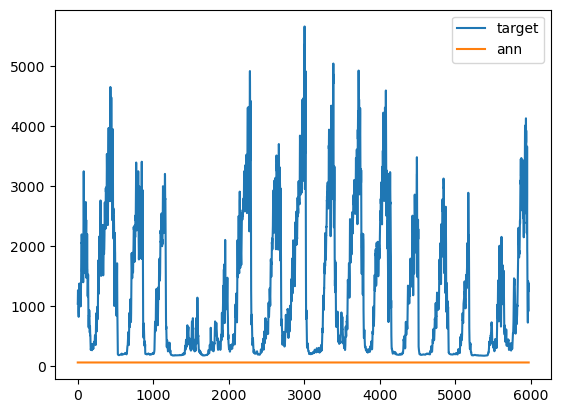

In [30]:
import matplotlib.pyplot as plt
ax = y_test.plot()
pred = pd.DataFrame(index=y_test.index,data= y_test_pred)
print(pred.iloc[-1])
pred.plot(ax=ax)
plt.legend(["target","ann"])

## Save the final model

In [31]:
############################################################################################
############# Please change the model_save_path to the direction you saved the files #######
############################################################################################

model_save_path = r'./Export/emmaton'
annec.save_model(model, model_save_path)

INFO:tensorflow:Assets written to: ./Export/emmaton\assets
Model saved at location: ./Export/emmaton


dd

In [32]:
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

loaded_model = tf.keras.models.load_model(
    model_save_path, 
    custom_objects={
        'root_mean_squared_error': root_mean_squared_error,
        'MinMaxScaler091': annec.MinMaxScaler091  # Add custom layer
    }
)
# Calculate metrics for ANN
metrics = []
y_train_pred = loaded_model.predict(X_train)
y_test_pred = loaded_model.predict(X_test)
metrics.append(annec.calculate_metrics('ANN', y_train, y_train_pred, y_test, y_test_pred))

df3 = pd.DataFrame(metrics)
print(tabulate(df3, headers='keys', tablefmt='psql'))

+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+
|    | Model   |   Train_R2 |   Train_RMSE |   Train_Percentage_Bias |   Test_R2 |   Test_RMSE |   Test_Percentage_Bias |
|----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------|
|  0 | ANN     |      -0.61 |       1104.2 |                  -80.65 |        -1 |     1545.05 |                 -85.83 |
+----+---------+------------+--------------+-------------------------+-----------+-------------+------------------------+


## Load the trained model and evaluate it on held-out data and a standalone sample

This section loads the trained ANN model and evaluates its performance on the held-out test dataset, followed by a standalone sample prediction using a raw 118-day history of the seven predictors.

The sample input is independent of the training and testing windows and demonstrates how the deployed model can be used for inference using only raw daily predictor values, with antecedents computed internally by the preprocessing layer.

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
import EC_estimator as annec

# ------------------------------------------------------------
# Custom metric (unchanged)
# ------------------------------------------------------------
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.keras.backend.sqrt(
        tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true))
    )

# ------------------------------------------------------------
# Load trained model
# ------------------------------------------------------------
loaded_model = tf.keras.models.load_model(
    model_save_path,
    custom_objects={
        "root_mean_squared_error": root_mean_squared_error,
        "MinMaxScaler091": annec.MinMaxScaler091  # Add custom layer
    }
)

# ------------------------------------------------------------
# Load sample input (118 rows × 7 predictors)
# ------------------------------------------------------------
df_sample = pd.read_csv("Inputs/selected_EC_7_feature.csv")

predictors = ["dcc","exports","sac","sjr","tide","net_dcd","smscg"]

# sanity check
if df_sample.shape != (118, 7):
    raise ValueError("Sample input must be 118 rows × 7 predictors")

df_sample = df_sample[predictors]

# ------------------------------------------------------------
# Build model input list: 7 × (1,118)
# ------------------------------------------------------------
X_sample = [
    df_sample[p].to_numpy().reshape(1, 118)
    for p in predictors
]

# ------------------------------------------------------------
# Predict
# ------------------------------------------------------------
y_sample_pred = loaded_model.predict(X_sample, verbose=0)

print("Predicted EC:", y_sample_pred[0, 0])

[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\importlib\__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module EC_estimator not in sys.modules
]


ValueError: in user code:

    c:\Users\hzamanis\Documents\Projects\cs3-surrogate-training\EC_estimator.py:32 call  *
        normalized = (x - self.min_val) / self.range
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\ops\math_ops.py:988 binary_op_wrapper
        y, dtype_hint=x.dtype.base_dtype, name="y")
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\ops.py:1283 convert_to_tensor_v2
        as_ref=False)
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\ops.py:1341 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\constant_op.py:321 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\constant_op.py:262 constant
        allow_broadcast=True)
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\constant_op.py:300 _constant_impl
        allow_broadcast=allow_broadcast))
    c:\Users\hzamanis\AppData\Local\anaconda3\envs\ECX2_220\lib\site-packages\tensorflow\python\framework\tensor_util.py:439 make_tensor_proto
        raise ValueError("None values not supported.")

    ValueError: None values not supported.
